In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import pickle

In [2]:
# Конфигурационные параметры
EMBEDDING_SIZE = 256  # Размер выходного эмбеддинга
IMAGE_SIZE = 224      # Размер изображения для ResNet
BATCH_SIZE = 32       # Размер батча для обработки

# Путь к папке с данными
DATA_PATH = 'images_train'

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class EmbeddingExtractor(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingExtractor, self).__init__()
        # Загрузка предобученной ResNet50
        self.resnet = models.resnet50(pretrained=True)
        # Удаляем последний полносвязный слой
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # Добавляем свой полносвязный слой для получения нужного размера эмбеддинга
        self.fc = nn.Linear(2048, embedding_size)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Разворачиваем в вектор
        x = self.fc(x)
        return x

In [4]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
            except:
                print(f'Error loading image {img_path}')
    return torch.stack(images)

In [6]:
def extract_embeddings(model_folders):
    model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
    model.eval()
    
    all_embeddings = []
    model_labels = []
    
    with torch.no_grad():
        for model_idx, folder in enumerate(model_folders):
            images = load_images_from_folder(folder)
            # Обрабатываем батчами для экономии памяти
            for i in range(0, len(images), BATCH_SIZE):
                batch = images[i:i+BATCH_SIZE].to(device)
                embeddings = model(batch)
                all_embeddings.append(embeddings.cpu().numpy())
                model_labels.extend([model_idx] * len(embeddings))
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    return all_embeddings, np.array(model_labels)

In [7]:
def normalize_embeddings(embeddings):
    scaler = StandardScaler()
    return scaler.fit_transform(embeddings)

def cluster_embeddings(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return clusters, kmeans.cluster_centers_

In [8]:
def ensure_cluster_separation(embeddings, clusters, centers, min_distance=5.0):
    """
    Гарантирует, что кластеры не находятся слишком близко друг к другу.
    Если кластеры слишком близки, перемещает их центры.
    """
    distances = euclidean_distances(centers)
    np.fill_diagonal(distances, np.inf)  # Игнорируем расстояние между одним и тем же кластером
    
    too_close = distances < min_distance
    while np.any(too_close):
        for i in range(len(centers)):
            for j in range(i+1, len(centers)):
                if distances[i, j] < min_distance:
                    # Перемещаем центры кластеров дальше друг от друга
                    direction = centers[i] - centers[j]
                    direction = direction / np.linalg.norm(direction)
                    centers[i] += direction * (min_distance - distances[i, j]) / 2
                    centers[j] -= direction * (min_distance - distances[i, j]) / 2
        
        distances = euclidean_distances(centers)
        np.fill_diagonal(distances, np.inf)
        too_close = distances < min_distance
    
    # Пересчитываем кластеры с новыми центрами
    new_clusters = []
    for emb in embeddings:
        dists = [np.linalg.norm(emb - center) for center in centers]
        new_clusters.append(np.argmin(dists))
    
    return np.array(new_clusters), centers

In [9]:
def visualize_clusters(embeddings_2d, clusters, model_labels):
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, 
                         cmap='tab20', alpha=0.6, edgecolors='w', linewidth=0.5)
    
    # Добавляем настоящие метки моделей для проверки
    for i, txt in enumerate(model_labels):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                     fontsize=8, alpha=0.5)
    
    plt.colorbar(scatter)
    plt.title('Cluster Visualization with Model Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

In [10]:
import random
from matplotlib import gridspec

def visualize_neighbors(embeddings, model_folders, n_samples=3, k_neighbors=5):
    """
    Визуализирует n случайных изображений и их k ближайших соседей в embedding-пространстве
    
    Args:
        embeddings: нормализованные эмбеддинги всех изображений
        model_folders: список путей к папкам с моделями
        n_samples: количество случайных изображений для анализа
        k_neighbors: количество ближайших соседей
    """
    # Собираем все изображения и их пути
    all_images = []
    image_paths = []
    
    for folder in model_folders:
        for filename in sorted(os.listdir(folder)):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                all_images.append(Image.open(img_path).convert('RGB'))
                image_paths.append(img_path)
    
    # Выбираем случайные индексы
    sample_indices = random.sample(range(len(embeddings)), n_samples)
    
    # Вычисляем попарные расстояния между всеми эмбеддингами
    distances = euclidean_distances(embeddings)
    
    for idx in sample_indices:
        # Находим k ближайших соседей (исключая само изображение)
        neighbors = np.argsort(distances[idx])[1:k_neighbors+1]
        
        # Создаем фигуру для отображения
        plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, k_neighbors+1, width_ratios=[1.2] + [1]*k_neighbors)
        
        # Отображаем исходное изображение
        plt.subplot(gs[0])
        plt.imshow(all_images[idx])
        plt.title(f"Query\n{os.path.basename(image_paths[idx])}")
        plt.axis('off')
        
        # Отображаем соседей
        for i, neighbor_idx in enumerate(neighbors, 1):
            plt.subplot(gs[i])
            plt.imshow(all_images[neighbor_idx])
            dist = distances[idx, neighbor_idx]
            plt.title(f"Dist: {dist:.2f}\n{os.path.basename(image_paths[neighbor_idx])}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

Found 10 model folders


D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted embeddings shape: (260, 256)
Embeddings normalized


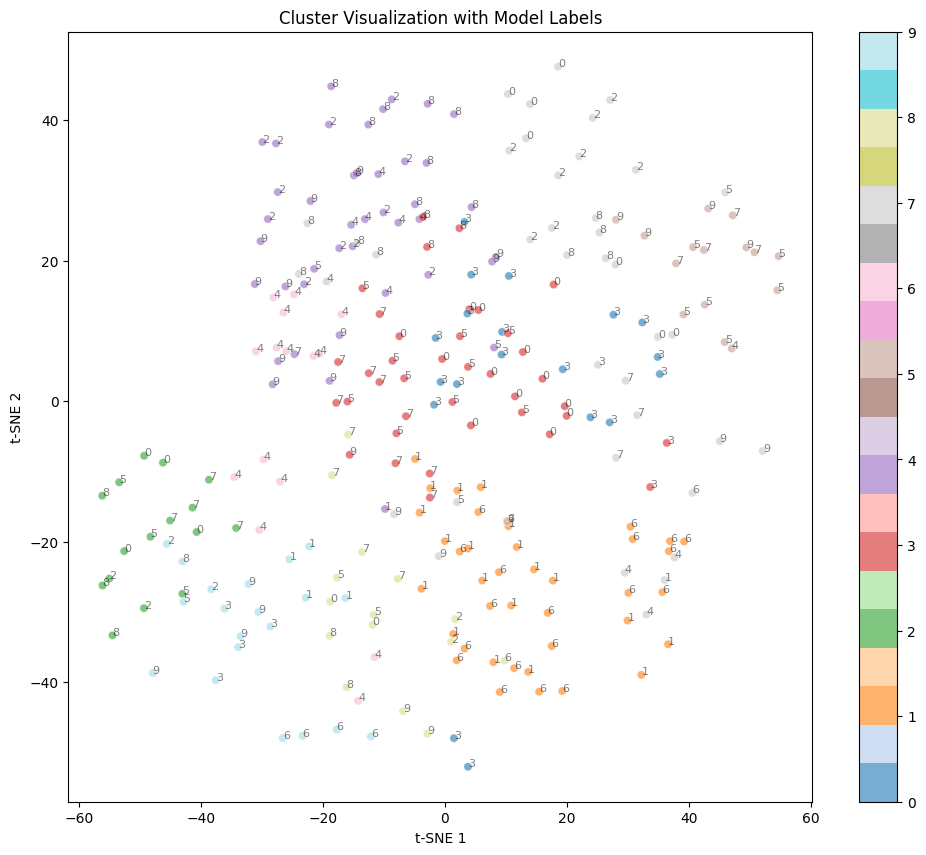

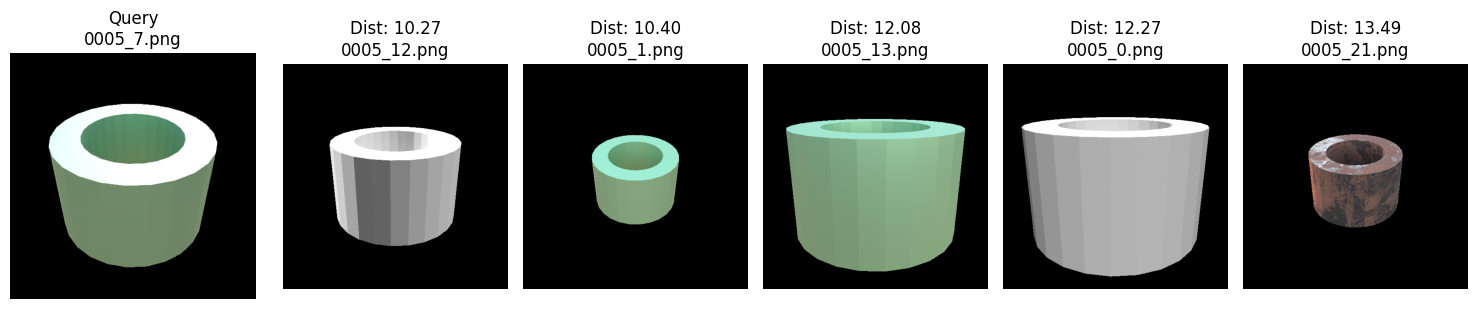

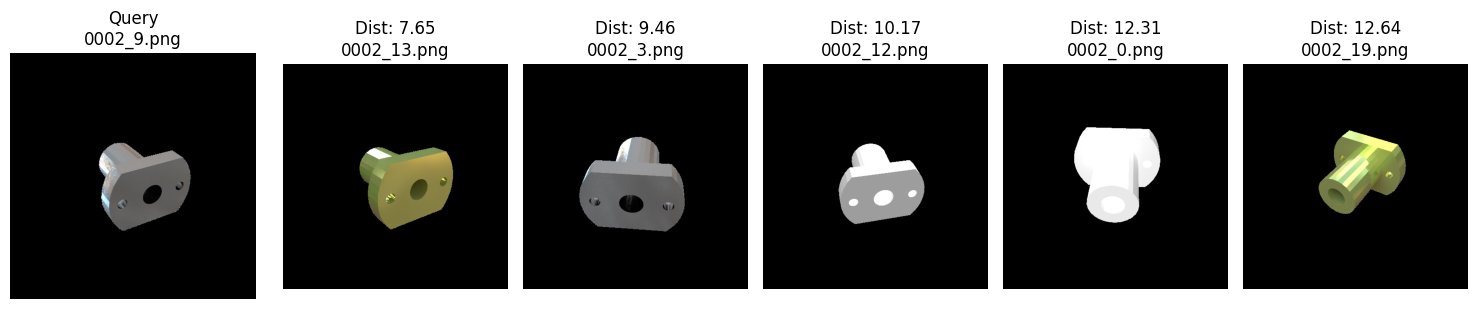

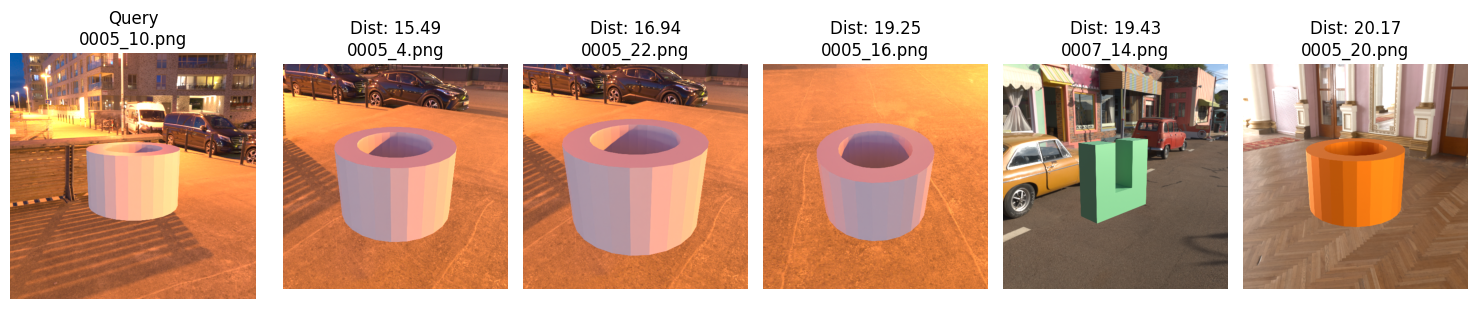

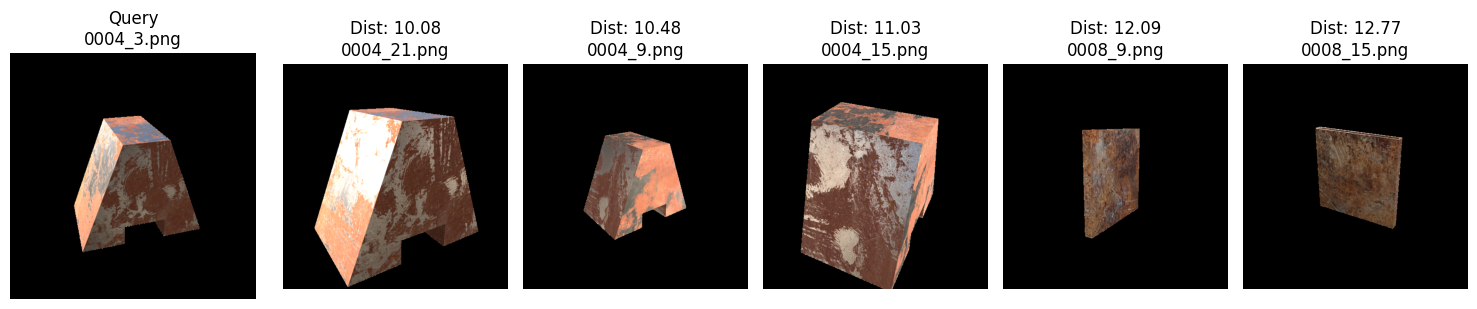

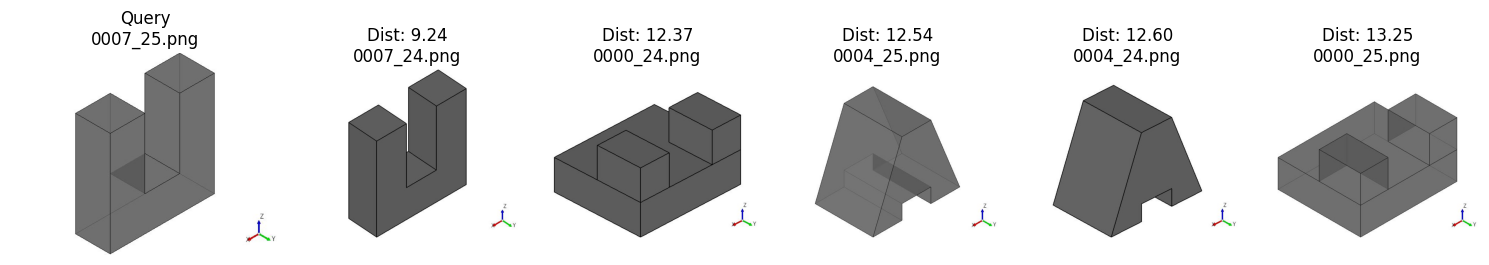

Results saved to disk


In [12]:
# Получаем список папок с моделями
model_folders = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
model_folders.sort()
    
print(f"Found {len(model_folders)} model folders")
    
# Извлекаем эмбеддинги
embeddings, model_labels = extract_embeddings(model_folders)
print(f"Extracted embeddings shape: {embeddings.shape}")
    
# Нормализуем эмбеддинги
normalized_embeddings = normalize_embeddings(embeddings)
print("Embeddings normalized")
    
# Кластеризация (количество кластеров = количеству моделей)
n_clusters = len(model_folders)
clusters, centers = cluster_embeddings(normalized_embeddings, n_clusters)
    
# Гарантируем разделение кластеров
separated_clusters, separated_centers = ensure_cluster_separation(
    normalized_embeddings, clusters, centers)
    
# Визуализация с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(normalized_embeddings)
    
visualize_clusters(embeddings_2d, separated_clusters, model_labels)
visualize_neighbors(normalized_embeddings, model_folders, n_samples=5, k_neighbors=5)
    
    
# Сохраняем результаты
np.save('model_embeddings.npy', normalized_embeddings)
np.save('model_labels.npy', model_labels)
np.save('cluster_labels.npy', separated_clusters)
print("Results saved to disk")

In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import trimesh
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from stl import mesh


In [32]:
# Загрузка данных
embeddings = np.load('model_embeddings.npy')  # (N, D)
labels = np.load('model_labels.npy')          # (N,)
cluster_labels = np.load('cluster_labels.npy')  # (N,)
centroids = np.array([embeddings[cluster_labels == i].mean(axis=0) for i in np.unique(cluster_labels)])  # (K, D)

# Пути к STL-файлам
stl_dir = "stl_dir"
stl_paths = [os.path.join(stl_dir, file) for file in os.listdir(stl_dir) if file.endswith(".stl")]
print(f"Found {len(stl_paths)} STL files")
# Проверка соответствия размеров
assert len(stl_paths) == len(centroids), "Number of STL files should match cluster labels count"


Found 10 STL files


In [33]:
from stl import mesh  # Импорт модуля

def get_rich_stl_features(stl_path):
    # Используем другое имя переменной (не 'mesh')
    stl_mesh = mesh.Mesh.from_file(stl_path)  # <- Исправлено здесь
    vertices = stl_mesh.vectors.reshape(-1, 3)
    
    # Базовые статистики
    vertex_mean = vertices.mean(axis=0)
    vertex_std = vertices.std(axis=0)
    
    # Геометрические метрики
    bbox_size = vertices.max(axis=0) - vertices.min(axis=0)
    surface_area = np.sum(np.linalg.norm(np.cross(
        stl_mesh.vectors[:, 1] - stl_mesh.vectors[:, 0],
        stl_mesh.vectors[:, 2] - stl_mesh.vectors[:, 0]
    ), axis=1))
    
    # Гистограммы распределения вершин
    hist_x = np.histogram(vertices[:, 0], bins=5)[0]
    
    # Дескрипторы формы (моменты инерции)
    cov_matrix = np.cov(vertices.T)
    eigvals = np.linalg.eigvals(cov_matrix)
    
    return np.concatenate([
        vertex_mean, vertex_std, bbox_size,
        [surface_area], hist_x, eigvals
    ])

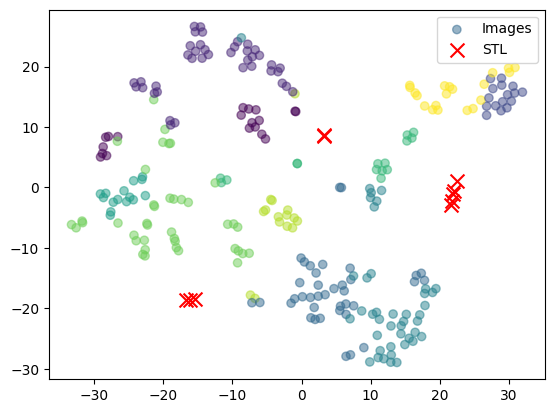

In [36]:
# 1. Улучшенные признаки STL
stl_embeddings = np.array([get_rich_stl_features(p) for p in stl_paths])

# 2. Раздельная стандартизация
scaler_images = StandardScaler().fit(embeddings)
scaler_stl = StandardScaler().fit(stl_embeddings)
emb_norm = scaler_images.transform(embeddings)
stl_norm = scaler_stl.transform(stl_embeddings)

# 3. Совместная визуализация t-SNE
# Дополнение STL-признаков до 256
stl_padded = np.zeros((stl_norm.shape[0], 256))
stl_padded[:, :stl_norm.shape[1]] = stl_norm

# Объединение
combined = np.vstack([emb_norm, stl_padded])

# t-SNE
tsne_results = TSNE(metric="cosine", perplexity=15).fit_transform(combined)

# Визуализация
plt.scatter(tsne_results[:len(embeddings), 0], 
            tsne_results[:len(embeddings), 1],
            c=cluster_labels, alpha=0.5, label='Images')
plt.scatter(tsne_results[len(embeddings):, 0],
            tsne_results[len(embeddings):, 1],
            marker='x', color='red', s=100, label='STL')
plt.legend()
plt.show()

In [20]:
import numpy as np
from stl import mesh
import os

def load_stl_features(stl_paths, target_dim=512):
    """Загружает STL-файлы и извлекает признаки (расширенная версия)."""
    stl_features = []
    for path in stl_paths:
        stl_mesh = mesh.Mesh.from_file(path)
        vertices = stl_mesh.vectors.reshape(-1, 3)  # Все вершины
        normals = stl_mesh.normals  # Нормали
        
        # Базовые признаки: среднее и std
        vertex_mean = vertices.mean(axis=0)
        vertex_std = vertices.std(axis=0)
        normal_mean = normals.mean(axis=0)
        normal_std = normals.std(axis=0)
        
        # Дополнительные признаки (например, гистограммы)
        vertex_hist = np.histogram(vertices[:, 0], bins=5)[0]  # Гистограмма по X
        normal_hist = np.histogram(normals[:, 0], bins=5)[0]
        
        features = np.concatenate([
            vertex_mean, vertex_std,
            normal_mean, normal_std,
            vertex_hist, normal_hist
        ])
        stl_features.append(features)
    
    stl_features = np.array(stl_features)
    
    # Если признаков меньше, чем target_dim, дополняем нулями (или PCA)
    if stl_features.shape[1] < target_dim:
        pad_width = ((0, 0), (0, target_dim - stl_features.shape[1]))
        stl_features = np.pad(stl_features, pad_width, mode='constant')
    elif stl_features.shape[1] > target_dim:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=target_dim)
        stl_features = pca.fit_transform(stl_features)
    
    return stl_features

# Извлекаем признаки STL
stl_embeddings = load_stl_features(stl_paths, target_dim=embeddings.shape[1])
print(f"STL embeddings shape: {stl_embeddings.shape}")

STL embeddings shape: (10, 256)


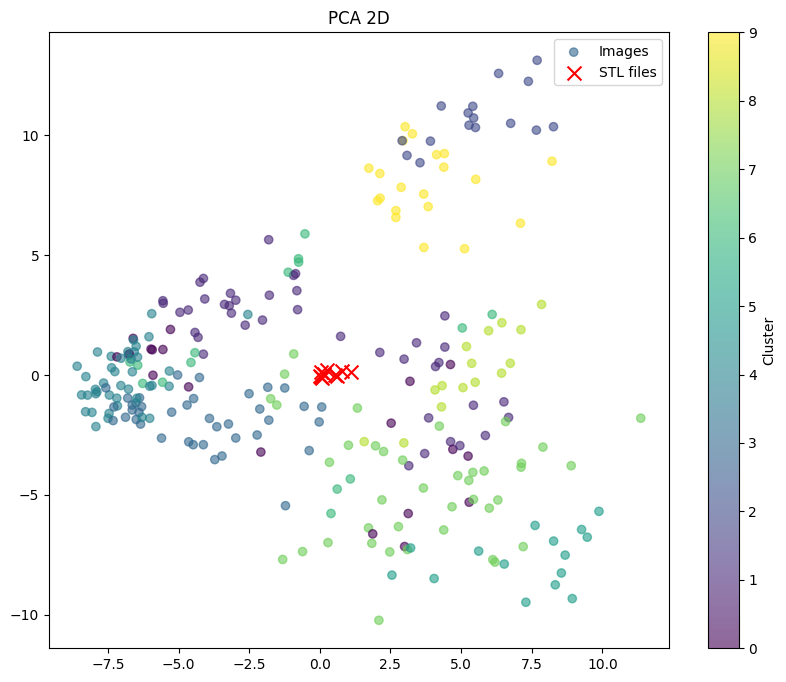

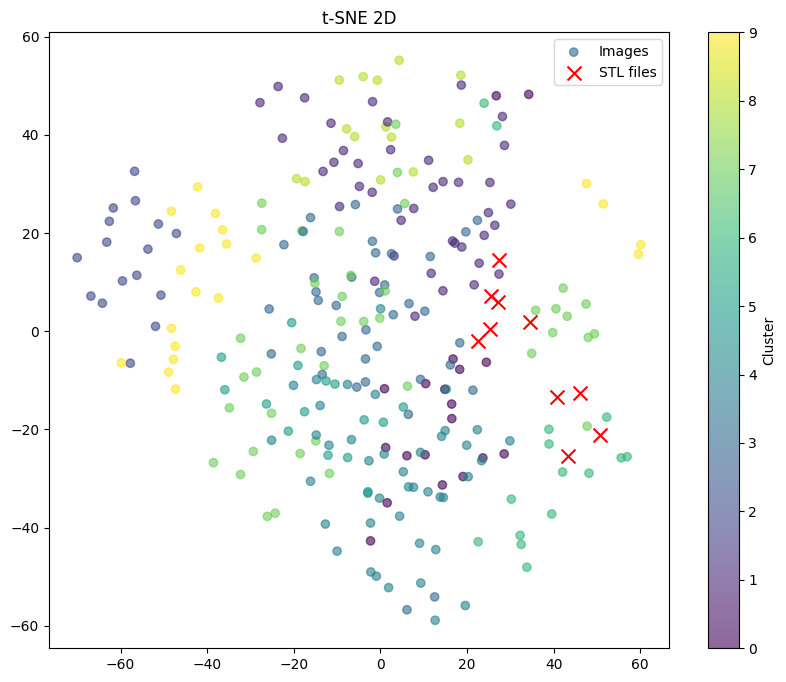

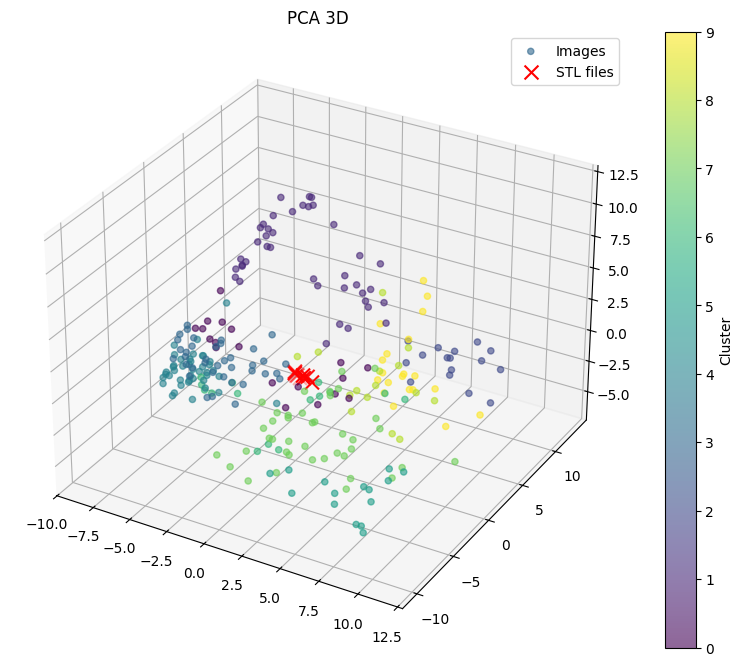

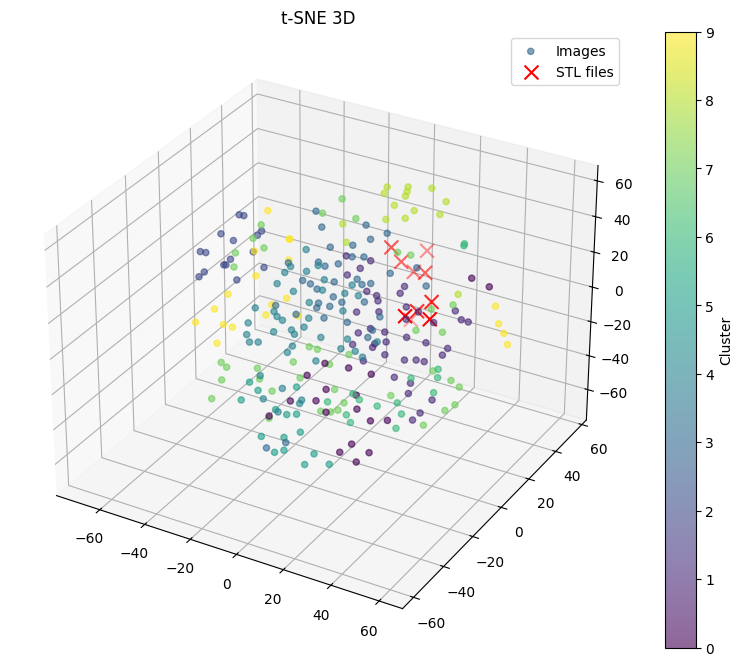

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embeddings(embeddings_2d, labels, stl_embeddings_2d, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Images')
    plt.scatter(stl_embeddings_2d[:, 0], stl_embeddings_2d[:, 1], marker='x', s=100, color='red', label='STL files')
    plt.legend()
    plt.title(title)
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Объединяем эмбеддинги для t-SNE и PCA
all_embeddings = np.vstack([embeddings, stl_embeddings])

from sklearn.preprocessing import StandardScaler

# Объединяем эмбеддинги изображений и STL
all_embeddings = np.vstack([embeddings, stl_embeddings])

# Масштабируем
scaler = StandardScaler()
all_embeddings_scaled = scaler.fit_transform(all_embeddings)

# Разделяем обратно
embeddings_scaled = all_embeddings_scaled[:len(embeddings)]
stl_embeddings_scaled = all_embeddings_scaled[len(embeddings):]
# Применяем PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings_scaled)
pca_images, pca_stl = pca_result[:len(embeddings)], pca_result[len(embeddings):]

# Применяем t-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(all_embeddings_scaled)
tsne_images, tsne_stl = tsne_result[:len(embeddings)], tsne_result[len(embeddings):]

# Визуализация в 2D
plot_embeddings(pca_images[:, :2], cluster_labels, pca_stl[:, :2], 'PCA 2D')
plot_embeddings(tsne_images[:, :2], cluster_labels, tsne_stl[:, :2], 't-SNE 2D')

# Визуализация в 3D
def plot_3d(embeddings_3d, labels, stl_embeddings_3d, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='viridis', alpha=0.6, label='Images')
    ax.scatter(stl_embeddings_3d[:, 0], stl_embeddings_3d[:, 1], stl_embeddings_3d[:, 2], marker='x', s=100, color='red', label='STL files')
    ax.legend()
    plt.title(title)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    plt.show()

plot_3d(pca_images, cluster_labels, pca_stl, 'PCA 3D')
plot_3d(tsne_images, cluster_labels, tsne_stl, 't-SNE 3D')

In [146]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import trimesh
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [190]:
# Загрузка данных
embeddings = np.load('model_embeddings.npy')  # (N, D)
labels = np.load('model_labels.npy')          # (N,)
cluster_labels = np.load('cluster_labels.npy')  # (N,)
centroids = np.array([embeddings[cluster_labels == i].mean(axis=0) for i in np.unique(cluster_labels)])  # (K, D)

# Пути к STL-файлам
stl_dir = "stl_dir"
stl_paths = [os.path.join(stl_dir, file) for file in os.listdir(stl_dir) if file.endswith(".stl")]
print(f"Found {len(stl_paths)} STL files")
# Проверка соответствия размеров
assert len(stl_paths) == len(centroids), "Number of STL files should match cluster labels count"


Found 10 STL files


In [148]:
print(len(embeddings))

260


In [160]:
# Класс для загрузки STL моделей
class STLDataset(Dataset):
    def __init__(self, stl_paths, cluster_labels, num_points=1024):
        self.stl_paths = stl_paths
        self.cluster_labels = cluster_labels
        self.num_points = num_points
        
    def __len__(self):
        return len(self.stl_paths)
    
    def __getitem__(self, idx):
        mesh = trimesh.load(self.stl_paths[idx])
        points = mesh.sample(self.num_points)
        points = (points - points.mean(axis=0)) / (points.std(axis=0) + 1e-8)
        points = torch.from_numpy(points).float().permute(1, 0)  # (3, N)
        label = torch.tensor(self.cluster_labels[idx], dtype=torch.long)
        return points, label


In [189]:
class PointNetEmbedding(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()
        # Чистые сверточные слои без BatchNorm/Dropout
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_dim, 1)
        self.fc = nn.Linear(output_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Без нормализации
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, dim=2)[0]
        x = self.fc(x)
        return x  # Без L2-нормализации

# Оптимизатор без weight_decay


In [151]:
# Функция для поиска сложных примеров
def get_hard_triplets(anchors, anchor_labels, all_embeddings, all_labels, k=5):
    """
    Возвращает hard positives и hard negatives для каждого anchor
    anchors: эмбеддинги текущего батча
    anchor_labels: метки текущего батча
    all_embeddings: все эмбеддинги изображений
    all_labels: все метки изображений
    """
    anchors = anchors.detach().cpu().numpy()
    anchor_labels = anchor_labels.detach().cpu().numpy()
    all_embeddings = all_embeddings.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    
    nbrs = NearestNeighbors(n_neighbors=k+100).fit(all_embeddings)
    distances, indices = nbrs.kneighbors(anchors)
    
    hard_positives = []
    hard_negatives = []
    
    for i, (label, neighbors) in enumerate(zip(anchor_labels, indices)):
        # Получаем маски для позитивов и негативов
        pos_mask = (all_labels[neighbors] == label)
        neg_mask = (all_labels[neighbors] != label)
        
        # Hard positive - самый далёкий из своего кластера
        if pos_mask.any():
            hard_pos = neighbors[pos_mask][-1]  # берём последний (самый далёкий)
        else:
            hard_pos = np.random.choice(np.where(all_labels == label)[0])
            
        # Hard negative - самый близкий из другого кластера
        if neg_mask.any():
            hard_neg = neighbors[neg_mask][0]  # берём первый (самый близкий)
        else:
            hard_neg = np.random.choice(np.where(all_labels != label)[0])
            
        hard_positives.append(all_embeddings[hard_pos])
        hard_negatives.append(all_embeddings[hard_neg])
    
    return (torch.from_numpy(np.array(hard_positives)).float().to(anchors.device),
            torch.from_numpy(np.array(hard_negatives)).float().to(anchors.device))

In [170]:
class ScaledTripletLoss(nn.Module):
    def __init__(self, scale=10.0):
        super().__init__()
        self.scale = scale
        
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = torch.log(1 + torch.exp(self.scale*(pos_dist - neg_dist)))
        return loss.mean()

In [177]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, x1, x2, label):
        dist = F.pairwise_distance(x1, x2)
        loss = (label * dist.pow(2) + 
               (1-label) * F.relu(self.margin - dist).pow(2))
        return loss.mean()

# Где label=1 для позитивных пар, 0 для негативных

In [191]:
# Функция обучения
def train_triplet_model(model, dataloader, image_embeddings, image_labels, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.TripletMarginLoss(margin=100.0)
    #criterion = ScaledTripletLoss(scale=10.0)
    #criterion = ContrastiveLoss(margin=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)  # Явный 0
    
    # Подготовка данных изображений
    image_embeddings_tensor = torch.from_numpy(image_embeddings).float().to(device)
    image_labels_tensor = torch.from_numpy(image_labels).long().to(device)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_points, batch_labels in pbar:
            batch_points = batch_points.to(device)
            batch_labels = batch_labels.to(device)
            
            # Получаем эмбеддинги 3D моделей
            anchors = model(batch_points)
            
            # Получаем hard triplets
            positives, negatives = get_hard_triplets(
                anchors, batch_labels, 
                image_embeddings_tensor, image_labels_tensor
            )
            
            # Вычисляем loss
            loss = criterion(anchors, positives, negatives)
            
            # Оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss/len(dataloader):.4f}")
    
    return model


In [153]:
class TripletSTLDataset(Dataset):
    def __init__(self, stl_paths, cluster_labels, num_points=1024):
        self.stl_paths = stl_paths
        self.cluster_labels = cluster_labels
        self.num_points = num_points

    def __len__(self):
        return len(self.stl_paths)

    def __getitem__(self, idx):
        mesh = trimesh.load(self.stl_paths[idx])
        points = mesh.sample(self.num_points)
        points = (points - points.mean(axis=0)) / (points.std(axis=0) + 1e-8)
        points = torch.from_numpy(points).float().permute(1, 0)  # (3, N)
        label = torch.tensor(self.cluster_labels[idx], dtype=torch.long)
        return points, label

In [154]:
class TripletLossDataset(STLDataset):
    def __getitem__(self, idx):
        points, anchor_label = super().__getitem__(idx)
        
        # Positive: центроид своего кластера
        positive = centroids_tensor[anchor_label]
        
        # Negative: центроид случайного другого кластера
        negative_label = np.random.choice([x for x in range(len(centroids)) if x != anchor_label])
        negative = centroids_tensor[negative_label]
        
        return points, anchor_label, positive, negative

In [192]:
# Подготовка данных
dataset = STLDataset(stl_paths, cluster_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Инициализация и обучение модели
model = PointNetEmbedding(output_dim=embeddings.shape[1])
trained_model = train_triplet_model(model, dataloader, embeddings, labels)

# Сохранение модели
torch.save(trained_model.state_dict(), 'pointnet_embedding.pth')

Epoch 1/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s, loss=104]


Epoch 1, Avg Loss: 104.0838


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s, loss=104]


Epoch 2, Avg Loss: 103.7614


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.33it/s, loss=103]


Epoch 3, Avg Loss: 103.1958


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.81it/s, loss=103]


Epoch 4, Avg Loss: 102.8600


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s, loss=103]


Epoch 5, Avg Loss: 102.6191


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.09it/s, loss=102]


Epoch 6, Avg Loss: 102.2646


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s, loss=102]


Epoch 7, Avg Loss: 102.1540


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s, loss=102]


Epoch 8, Avg Loss: 102.0583


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s, loss=102]


Epoch 9, Avg Loss: 102.0230


Epoch 10/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s, loss=102]


Epoch 10, Avg Loss: 102.1191


Epoch 11/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s, loss=102]


Epoch 11, Avg Loss: 101.8140


Epoch 12/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s, loss=102]


Epoch 12, Avg Loss: 101.8114


Epoch 13/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s, loss=102]


Epoch 13, Avg Loss: 101.8497


Epoch 14/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s, loss=102]


Epoch 14, Avg Loss: 101.7922


Epoch 15/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s, loss=102]


Epoch 15, Avg Loss: 101.6955


Epoch 16/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.94it/s, loss=101]


Epoch 16, Avg Loss: 101.4874


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s, loss=101]


Epoch 17, Avg Loss: 101.3501


Epoch 18/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s, loss=101]


Epoch 18, Avg Loss: 101.3616


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s, loss=101]


Epoch 19, Avg Loss: 101.3490


Epoch 20/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s, loss=101]


Epoch 20, Avg Loss: 101.3019


Epoch 21/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s, loss=101]


Epoch 21, Avg Loss: 101.1558


Epoch 22/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s, loss=101]


Epoch 22, Avg Loss: 101.0845


Epoch 23/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=101]


Epoch 23, Avg Loss: 101.0363


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=101]


Epoch 24, Avg Loss: 100.9802


Epoch 25/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s, loss=101]


Epoch 25, Avg Loss: 100.9672


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=101]


Epoch 26, Avg Loss: 101.0778


Epoch 27/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s, loss=101]


Epoch 27, Avg Loss: 101.4745


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s, loss=101]


Epoch 28, Avg Loss: 101.4234


Epoch 29/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s, loss=101]


Epoch 29, Avg Loss: 101.3598


Epoch 30/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s, loss=101]


Epoch 30, Avg Loss: 101.2198


Epoch 31/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s, loss=101]


Epoch 31, Avg Loss: 101.1609


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s, loss=101]


Epoch 32, Avg Loss: 101.0004


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s, loss=101]


Epoch 33, Avg Loss: 101.0412


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=101]


Epoch 34, Avg Loss: 100.9854


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=101]


Epoch 35, Avg Loss: 100.9561


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s, loss=101]


Epoch 36, Avg Loss: 100.9320


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=101]


Epoch 37, Avg Loss: 100.8551


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s, loss=101]


Epoch 38, Avg Loss: 100.8073


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=101]


Epoch 39, Avg Loss: 100.7380


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s, loss=101]


Epoch 40, Avg Loss: 100.6284


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=101]


Epoch 41, Avg Loss: 100.5875


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s, loss=101]


Epoch 42, Avg Loss: 100.5983


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s, loss=101]


Epoch 43, Avg Loss: 100.5876


Epoch 44/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s, loss=101]


Epoch 44, Avg Loss: 100.5539


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s, loss=101]


Epoch 45, Avg Loss: 100.5669


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s, loss=101]


Epoch 46, Avg Loss: 100.5019


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s, loss=101]


Epoch 47, Avg Loss: 100.5440


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s, loss=101]


Epoch 48, Avg Loss: 100.5089


Epoch 49/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s, loss=100]


Epoch 49, Avg Loss: 100.4511


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s, loss=100]

Epoch 50, Avg Loss: 100.4724


In [156]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def visualize_embeddings(stl_embeddings, stl_labels, centroids, image_embeddings=None, image_labels=None):
    """
    Улучшенная визуализация с галочками для STL и квадратами для изображений
    
    Параметры:
    - stl_embeddings: эмбеддинги STL моделей (n_samples, dim)
    - stl_labels: метки кластеров для STL (n_samples,)
    - centroids: центроиды кластеров (n_clusters, dim)
    - image_embeddings: опционально - эмбеддинги изображений
    - image_labels: опционально - метки изображений
    """
    # 1. Подготовка данных
    n_samples = stl_embeddings.shape[0]
    perplexity = min(30, max(5, n_samples // 4))
    
    # 2. Совместное преобразование
    all_data = np.vstack([stl_embeddings, centroids])
    if image_embeddings is not None:
        all_data = np.vstack([all_data, image_embeddings])
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=500)
    tsne_results = tsne.fit_transform(all_data)
    
    # 3. Разделение результатов
    stl_tsne = tsne_results[:n_samples]
    centroids_tsne = tsne_results[n_samples:n_samples+len(centroids)]
    
    # 4. Визуализация с улучшенными стилями
    plt.figure(figsize=(16, 12))
    
    # Настройка цветовой карты
    cmap = plt.cm.get_cmap('tab20', len(np.unique(stl_labels)))
    
    # STL модели (галочки)
    for cluster in np.unique(stl_labels):
        mask = stl_labels == cluster
        plt.scatter(
            stl_tsne[mask, 0], stl_tsne[mask, 1],
            c=[cmap(cluster)], 
            marker='$\u2713$',  # Символ галочки
            s=150,             # Увеличенный размер
            alpha=0.9,         # Минимальная прозрачность
            edgecolors='k',    # Черная обводка
            linewidths=0.5,
            label=f'STL Cluster {cluster}'
        )
    
    # Центроиды (звезды)
    plt.scatter(
        centroids_tsne[:, 0], centroids_tsne[:, 1],
        c='red', marker='*', s=400,
        edgecolors='gold', linewidths=1,
        label='Cluster Centers'
    )
    
    # Изображения (полупрозрачные квадраты)
    if image_embeddings is not None:
        image_tsne = tsne_results[n_samples+len(centroids):]
        plt.scatter(
            image_tsne[:, 0], image_tsne[:, 1],
            c=image_labels, 
            marker='s',       # Квадраты
            s=50,            # Меньший размер
            alpha=0.3,       # Полупрозрачные
            cmap='tab20',
            edgecolors='none',
            label='Images'
        )
    
    # Настройки графика
    plt.title(f'2D t-SNE Projection\nSTL Models (✓) vs Images (□)', fontsize=14, pad=20)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(alpha=0.1)
    
    # Улучшенная легенда
    legend = plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        framealpha=1,
        title='Legend'
    )
    
    # Цветовая шкала для кластеров
    cbar = plt.colorbar(ticks=np.unique(stl_labels), pad=0.01)
    cbar.set_label('Cluster ID', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

    # Аналитика кластеров
    print("\nCluster Distribution (STL Models):")
    for cluster, count in zip(*np.unique(stl_labels, return_counts=True)):
        print(f"Cluster {cluster}: {count} models")

C:\Users\Huawei\AppData\Local\Temp\ipykernel_18528\530312876.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(np.unique(stl_labels)))


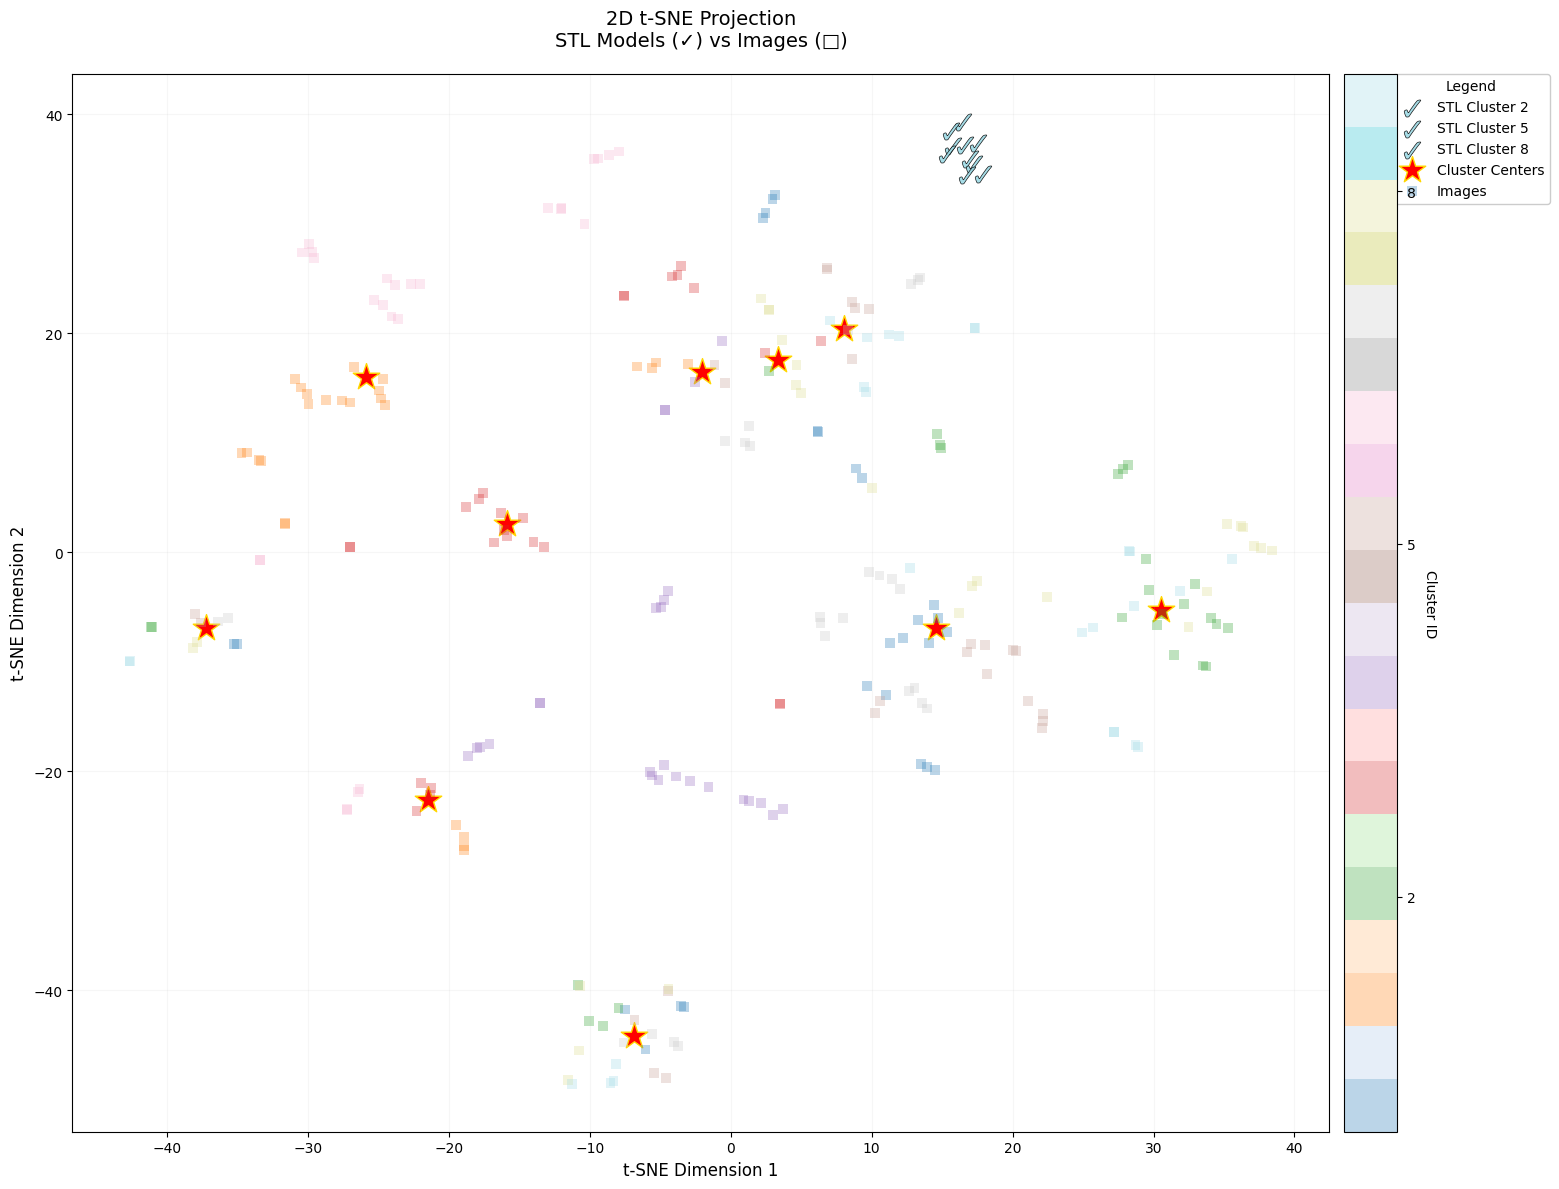


Cluster Distribution (STL Models):
Cluster 2: 5 models
Cluster 5: 3 models
Cluster 8: 2 models


In [193]:
# Пример использования:
model.eval()
all_stl_embeddings = []
all_labels = []

with torch.no_grad():
    for points, labels in dataloader:
        points = points.to(device)
        temp_embeddings = model(points)
        all_stl_embeddings.append(temp_embeddings.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

stl_embeddings = np.concatenate(all_stl_embeddings, axis=0)
stl_labels = np.concatenate(all_labels, axis=0)

# Вызов визуализации
visualize_embeddings(
    stl_embeddings=stl_embeddings,
    stl_labels=stl_labels,
    centroids=centroids,
    image_embeddings=image_embeddings,  # опционально
    image_labels=image_labels           # опционально
)

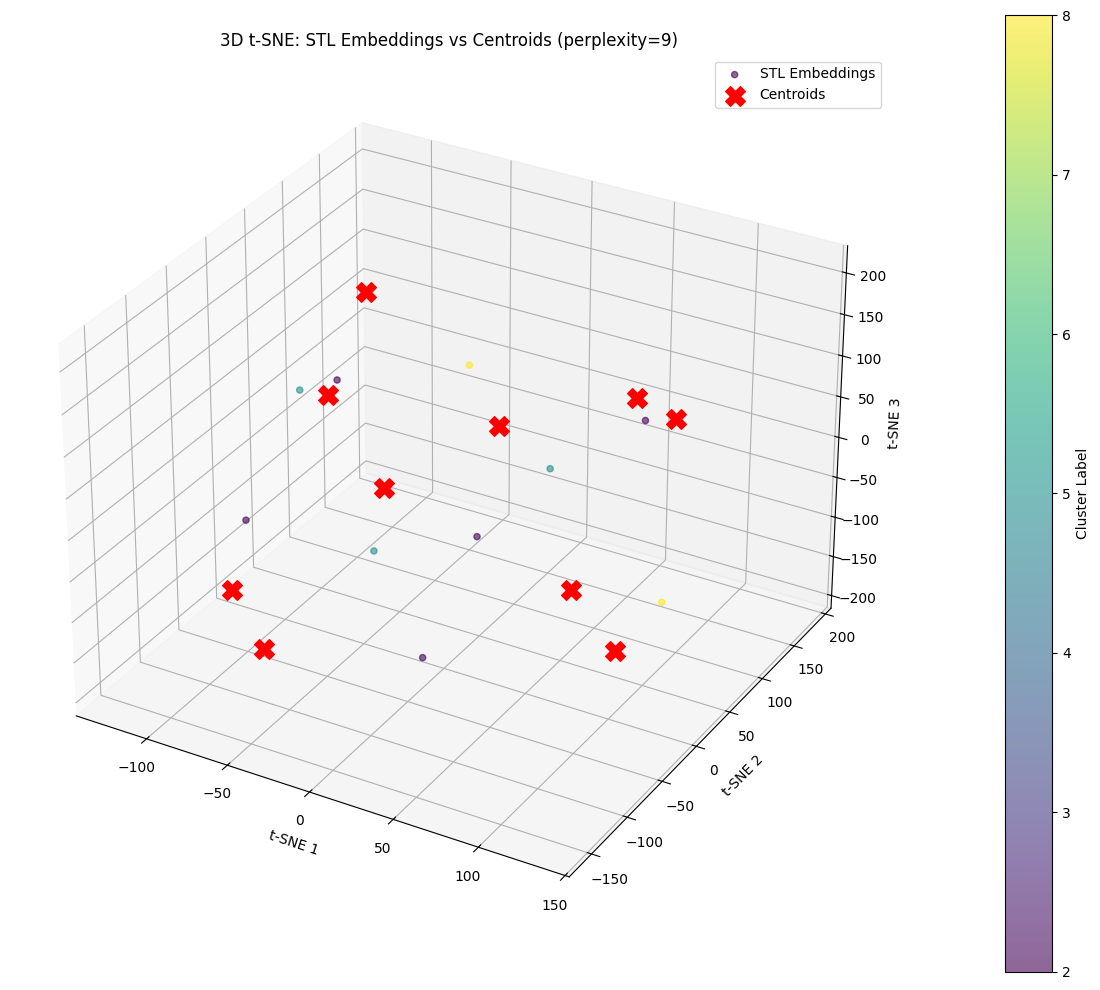

In [194]:
# 3D t-SNE визуализация
if n_samples >= 3:  # Для 3D нужно минимум 3 точки
    tsne_3d = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    stl_tsne_3d = tsne_3d.fit_transform(stl_embeddings)
    centroids_tsne_3d = tsne_3d.fit_transform(centroids)
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Визуализация STL эмбеддингов
    scatter = ax.scatter(
        stl_tsne_3d[:, 0], 
        stl_tsne_3d[:, 1],
        stl_tsne_3d[:, 2],
        c=stl_labels,
        alpha=0.6,
        cmap='viridis',
        label='STL Embeddings'
    )
    
    # Визуализация центроидов
    ax.scatter(
        centroids_tsne_3d[:, 0],
        centroids_tsne_3d[:, 1],
        centroids_tsne_3d[:, 2],
        c='red',
        marker='X',
        s=200,
        label='Centroids',
        depthshade=False
    )
    
    ax.set_title(f'3D t-SNE: STL Embeddings vs Centroids (perplexity={perplexity})')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    plt.legend()
    
    # Добавляем цветовую шкалу для кластеров
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Cluster Label')
    
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для 3D t-SNE (n_samples < 3)")

In [80]:
print(len(stl_embeddings))

10


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import os
from tqdm import tqdm

def visualize_stl_to_image_neighbors(
    stl_embeddings,
    image_embeddings,
    stl_paths,
    image_paths,
    stl_labels,
    image_cluster_labels,  # Метки кластеров для каждого изображения
    n_neighbors=10,
    n_samples=5,
    fig_width=20
):
    """
    Визуализация ближайших изображений для STL файлов
    
    Параметры:
    - stl_embeddings: (n_stl, dim) - эмбеддинги STL моделей
    - image_embeddings: (n_images, dim) - эмбеддинги изображений
    - stl_paths: список путей к STL файлам (длина n_stl)
    - image_paths: список путей к изображениям (длина n_images)
    - stl_labels: (n_stl,) - метки кластеров для STL
    - image_cluster_labels: (n_images,) - метки кластеров для изображений
    - n_neighbors: количество соседей для отображения
    - n_samples: количество STL для визуализации
    """
    # Проверка размеров
    n_stl = len(stl_paths)
    n_images = len(image_paths)
    
    # Проверка STL данных
    if len(stl_embeddings) != n_stl or len(stl_labels) != n_stl:
        raise ValueError(
            f"Несоответствие размеров STL данных:\n"
            f"Эмбеддинги: {len(stl_embeddings)}, Пути: {n_stl}, Метки: {len(stl_labels)}"
        )
    
    # Проверка Image данных
    if len(image_embeddings) != n_images or len(image_cluster_labels) != n_images:
        raise ValueError(
            f"Несоответствие размеров Image данных:\n"
            f"Эмбеддинги: {len(image_embeddings)}, Пути: {n_images}, Метки: {len(image_cluster_labels)}"
        )

    # Автоматическая корректировка числа соседей
    actual_neighbors = min(n_neighbors, n_images)
    if actual_neighbors < n_neighbors:
        print(f"Уменьшено число соседей с {n_neighbors} до {actual_neighbors} (мало изображений)")

    # Поиск ближайших соседей среди изображений
    nbrs = NearestNeighbors(n_neighbors=actual_neighbors)
    nbrs.fit(image_embeddings)
    
    # Выбор STL для отображения
    sample_indices = np.random.choice(n_stl, size=min(n_samples, n_stl), replace=False)
    
    for idx in tqdm(sample_indices, desc="Обработка STL"):
        try:
            # Получаем соседей среди изображений
            distances, neighbor_indices = nbrs.kneighbors([stl_embeddings[idx]])
            
            # Создаем фигуру
            fig, axes = plt.subplots(1, actual_neighbors, 
                                   figsize=(fig_width, fig_width/actual_neighbors*1.2))
            if actual_neighbors == 1:
                axes = [axes]  # Костыль для одного соседа
            
            # Заголовок с информацией о STL
            stl_name = os.path.basename(stl_paths[idx])
            stl_cluster = stl_labels[idx]
            fig.suptitle(f"STL: {stl_name}\nCluster: {stl_cluster}", y=1.05)
            
            # Отображаем соседние изображения
            for i, (img_idx, dist) in enumerate(zip(neighbor_indices[0], distances[0])):
                ax = axes[i]
                
                try:
                    # Загрузка и отображение изображения
                    img = Image.open(image_paths[img_idx])
                    ax.imshow(img)
                    
                    # Цвет рамки (зеленый = тот же кластер)
                    same_cluster = image_cluster_labels[img_idx] == stl_cluster
                    border_color = 'limegreen' if same_cluster else 'red'
                    
                    # Настройка отображения
                    for spine in ax.spines.values():
                        spine.set_edgecolor(border_color)
                        spine.set_linewidth(3)
                    
                    ax.set_title(f"Dist: {dist:.2f}\nCluster: {image_cluster_labels[img_idx]}", fontsize=9)
                    ax.axis('off')
                
                except Exception as e:
                    ax.set_title(f"Error loading image", fontsize=8)
                    ax.text(0.5, 0.5, "X", ha='center', va='center', color='red')
                    ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Ошибка при обработке {stl_paths[idx]}: {str(e)}")
            continue


In [64]:
# Получаем список папок с моделями
model_folders = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
model_folders.sort()

all_images = []
image_paths = []
    
for folder in model_folders:
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            all_images.append(Image.open(img_path).convert('RGB'))
            image_paths.append(img_path)

In [81]:
print(len(embeddings))
print(len(stl_embeddings))
print(len(stl_labels))

260
10
10


In [83]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. Преобразуем центроиды в метки для каждого изображения
nbrs = NearestNeighbors(n_neighbors=1).fit(centroids)
_, image_cluster_labels = nbrs.kneighbors(embeddings)
image_cluster_labels = image_cluster_labels.flatten()  # Преобразуем в одномерный массив

# Теперь image_cluster_labels содержит метки кластеров для каждого из 260 изображений
print(f"Метки кластеров для изображений: {image_cluster_labels.shape}")  # Должно быть (260,)

# 2. Проверяем размерности
assert len(embeddings) == len(image_paths) == len(image_cluster_labels), \
    f"Размеры должны совпадать: {len(embeddings)} эмбеддингов, {len(image_paths)} путей, {len(image_cluster_labels)} меток"


Метки кластеров для изображений: (260,)


Обработка STL:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

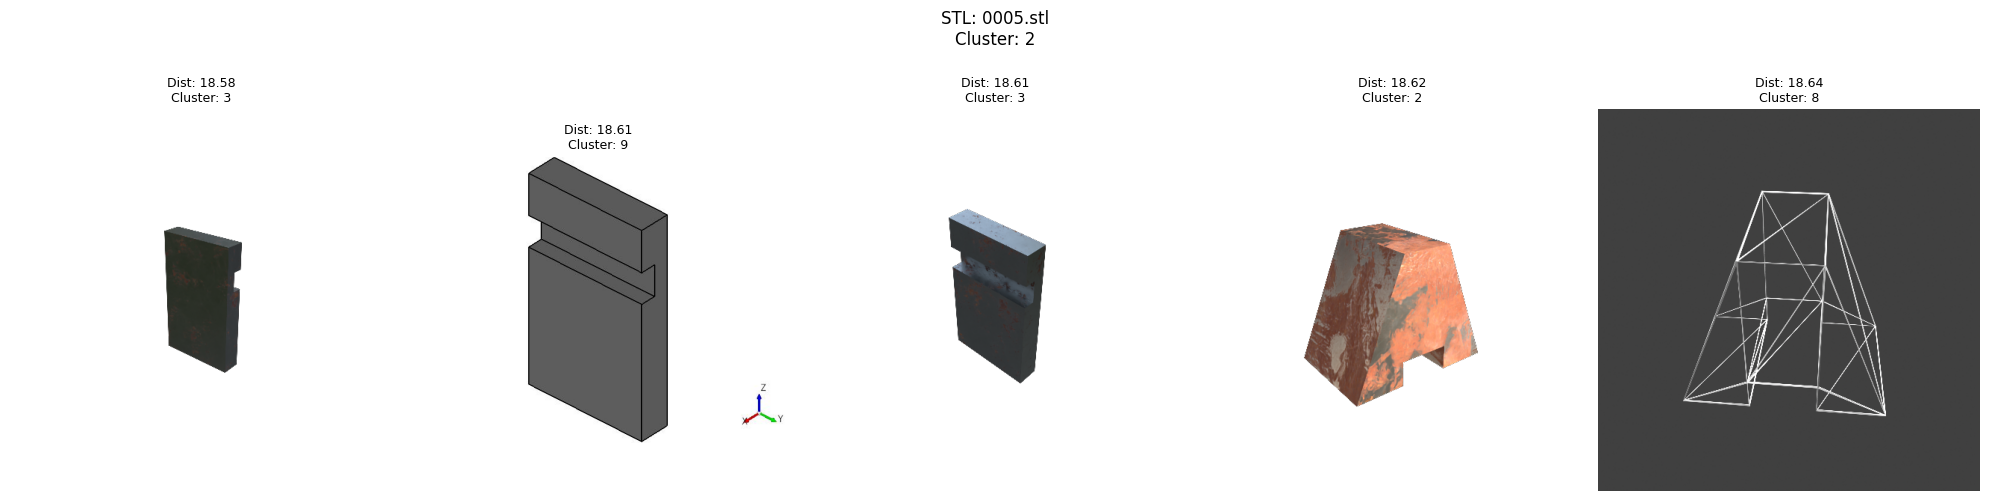

Обработка STL:  10%|██████▊                                                             | 1/10 [00:00<00:03,  2.66it/s]

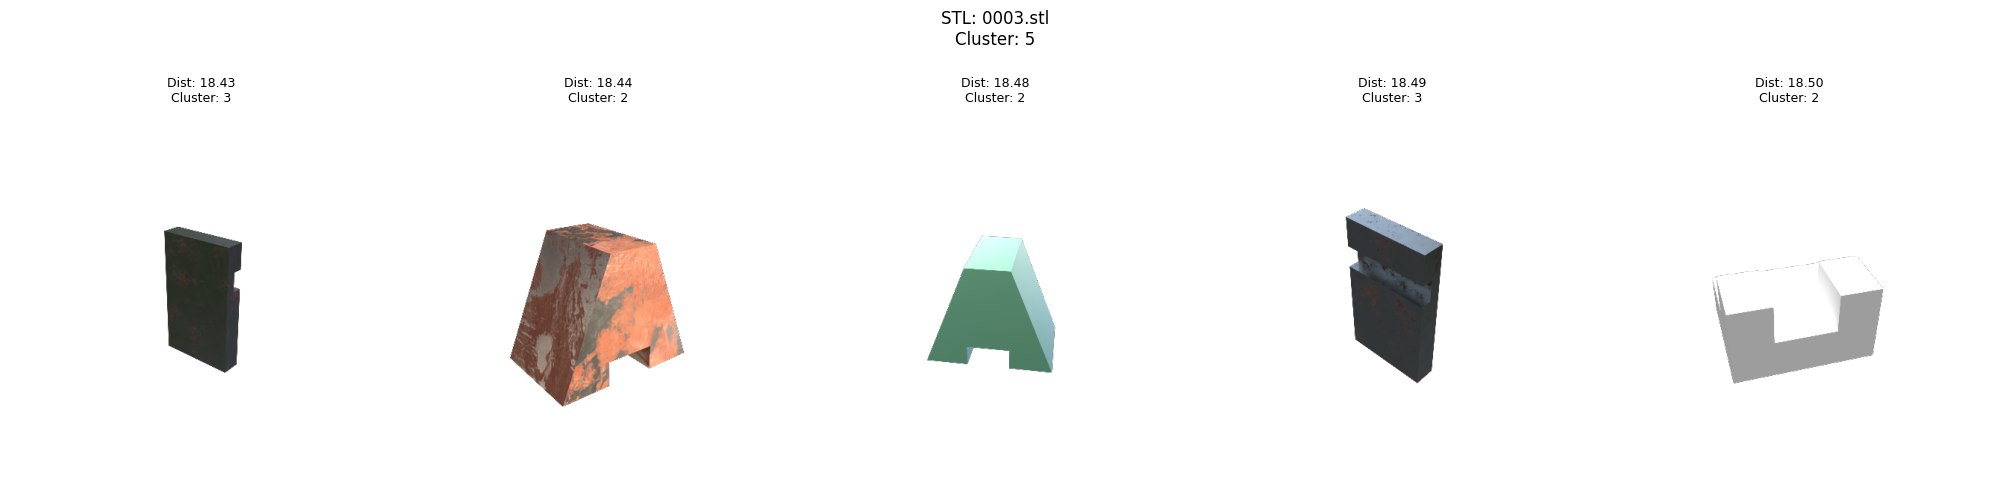

Обработка STL:  20%|█████████████▌                                                      | 2/10 [00:00<00:03,  2.64it/s]

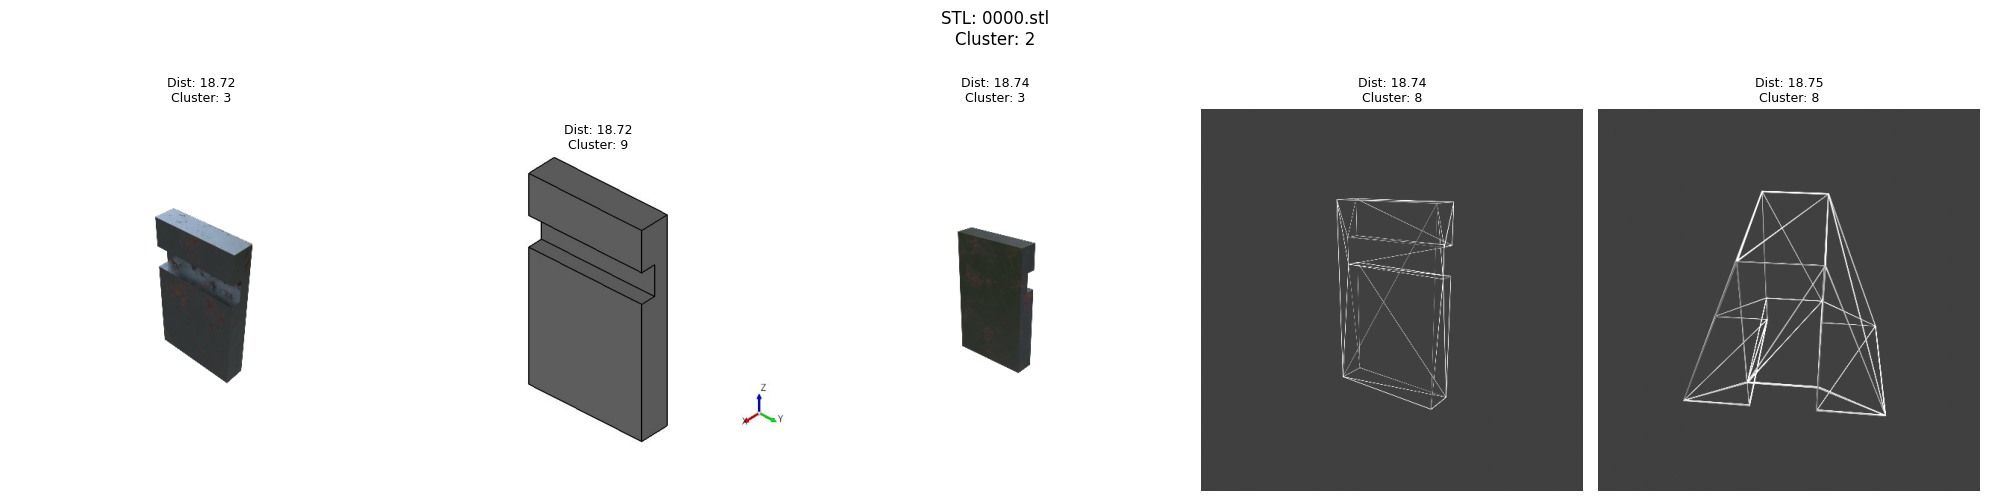

Обработка STL:  30%|████████████████████▍                                               | 3/10 [00:01<00:02,  2.41it/s]

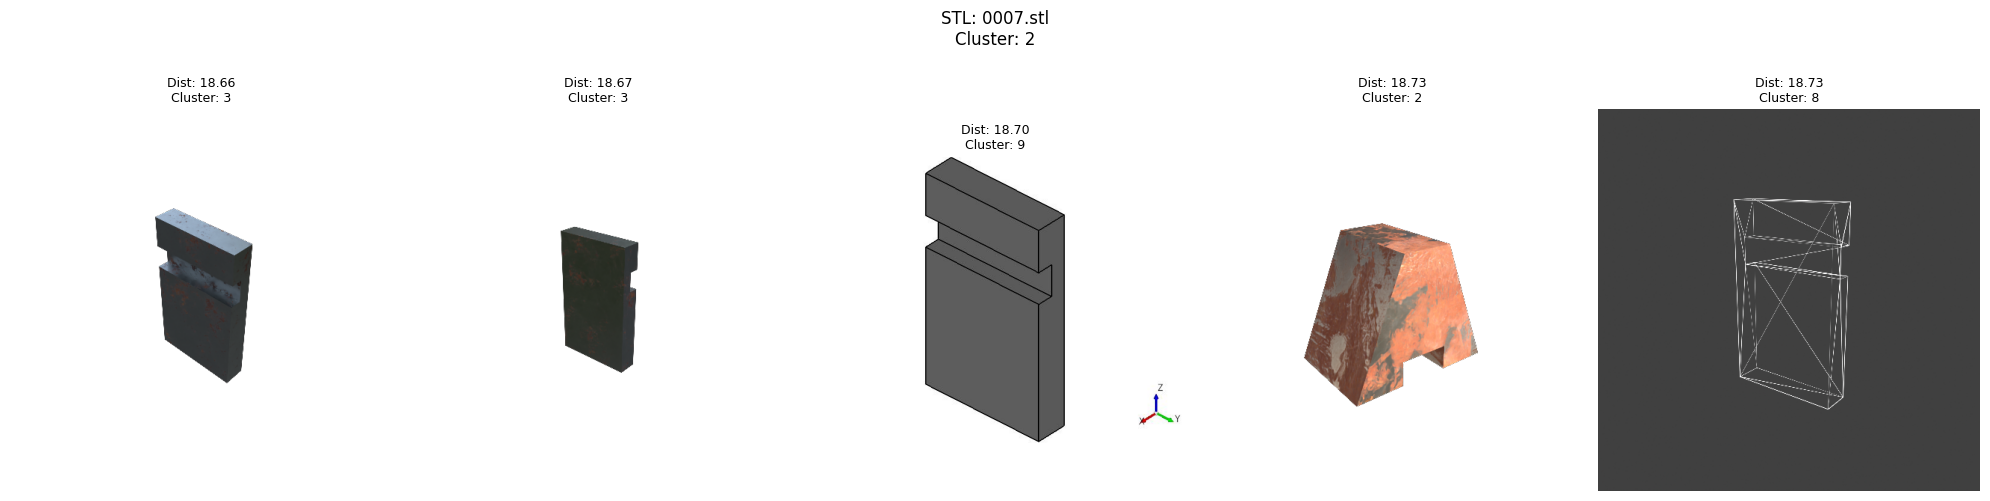

Обработка STL:  40%|███████████████████████████▏                                        | 4/10 [00:02<00:03,  1.73it/s]

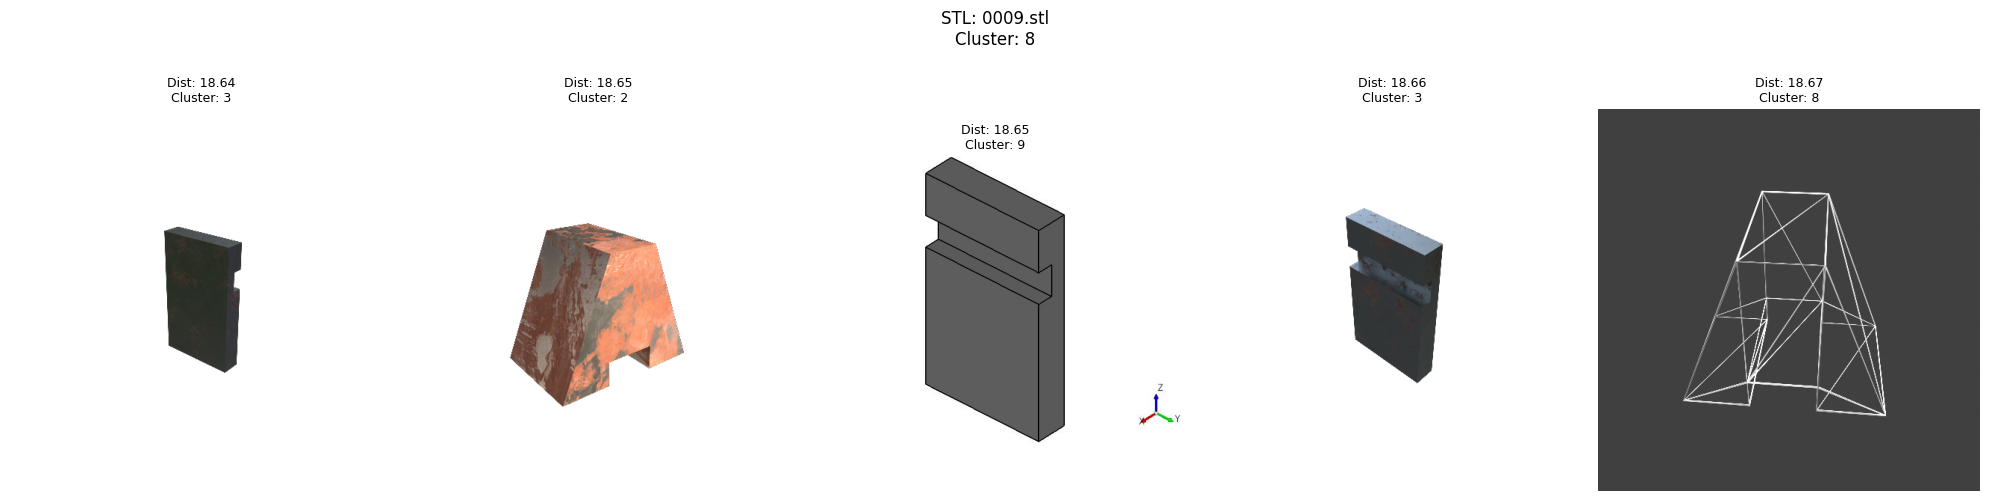

Обработка STL:  50%|██████████████████████████████████                                  | 5/10 [00:02<00:02,  1.95it/s]

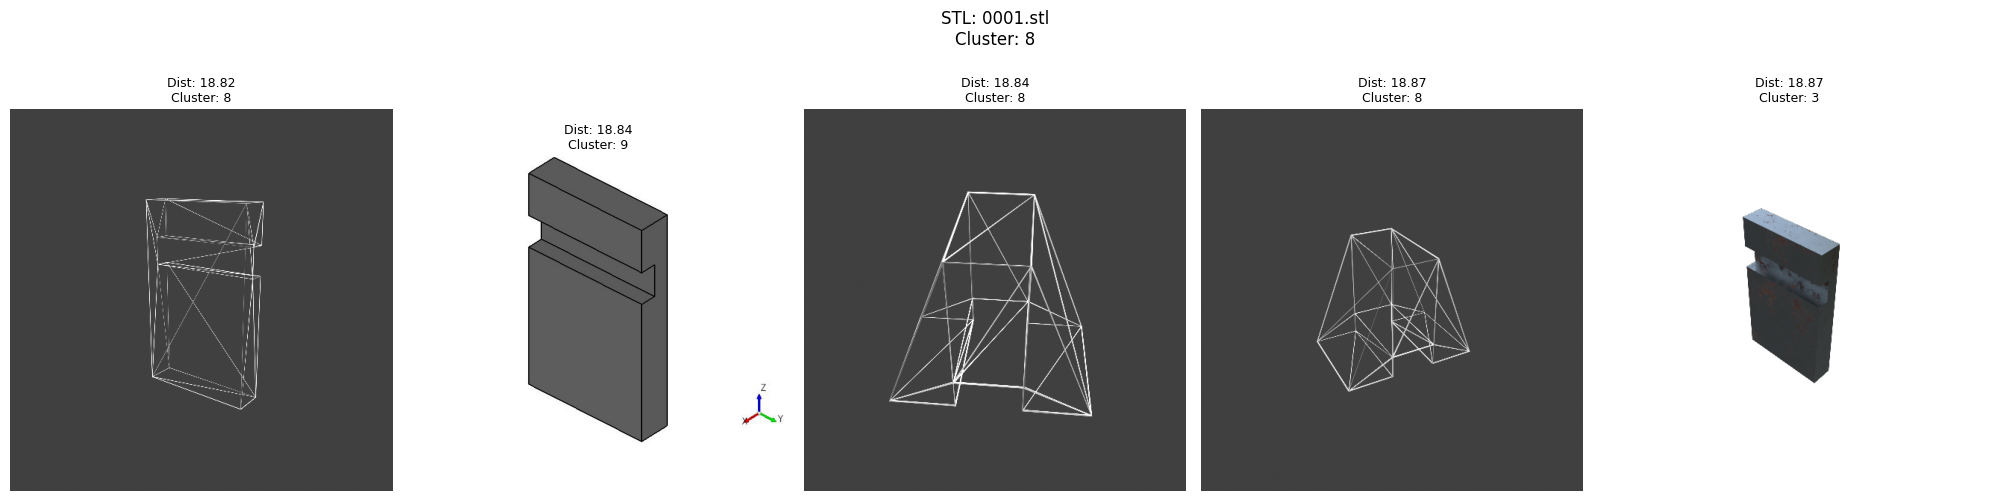

Обработка STL:  60%|████████████████████████████████████████▊                           | 6/10 [00:02<00:01,  2.11it/s]

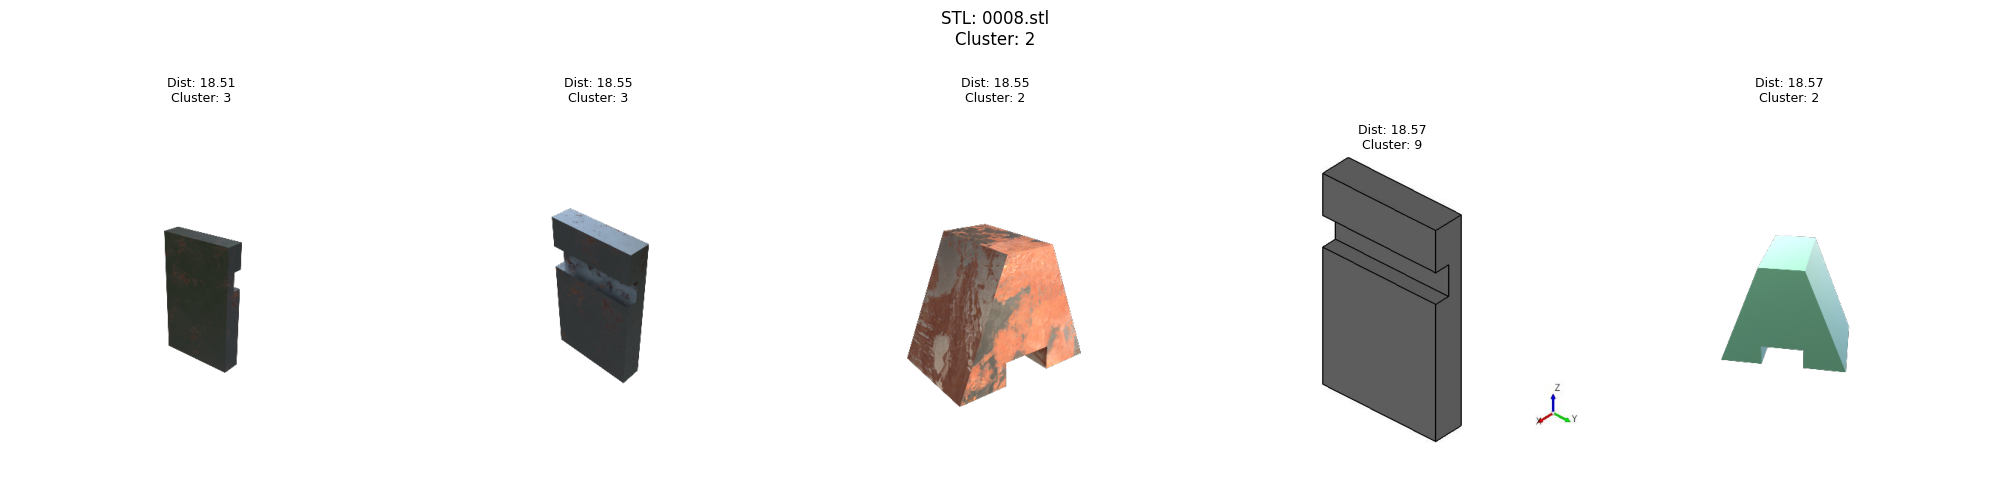

Обработка STL:  70%|███████████████████████████████████████████████▌                    | 7/10 [00:03<00:01,  2.20it/s]

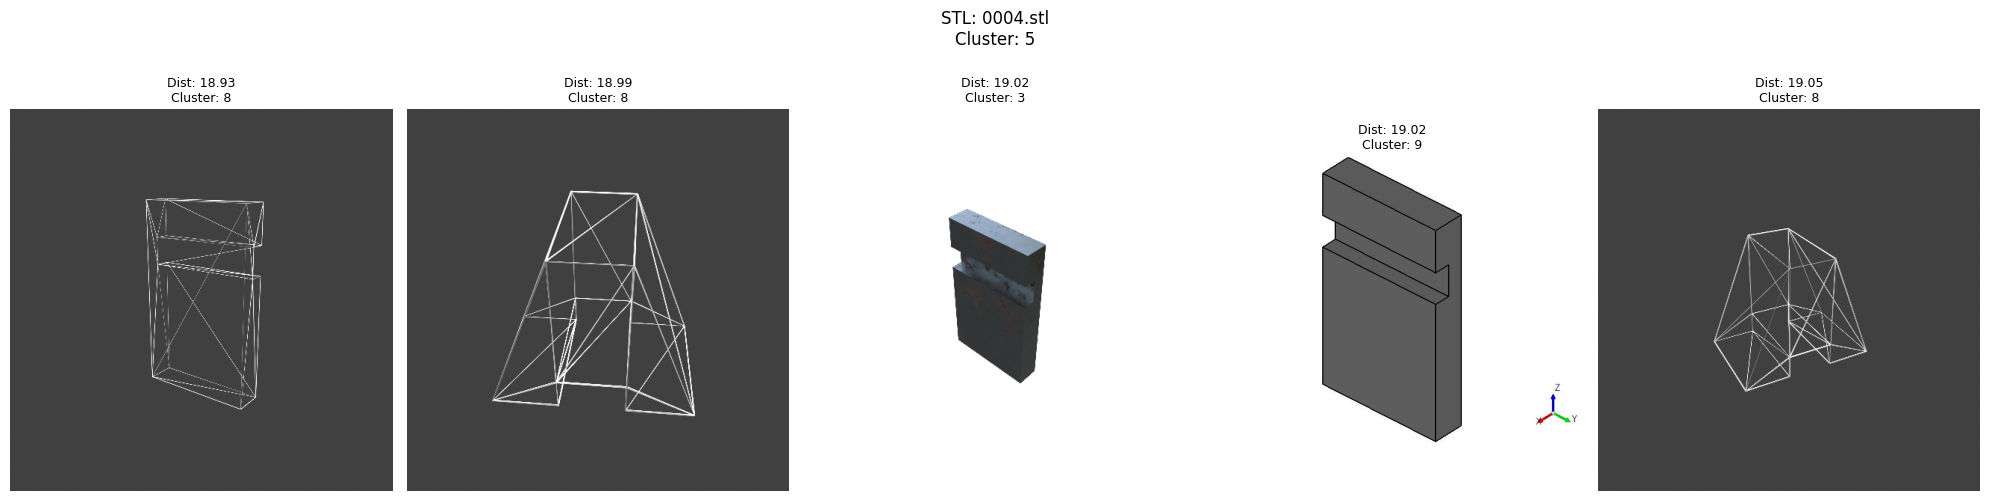

Обработка STL:  80%|██████████████████████████████████████████████████████▍             | 8/10 [00:03<00:01,  1.91it/s]

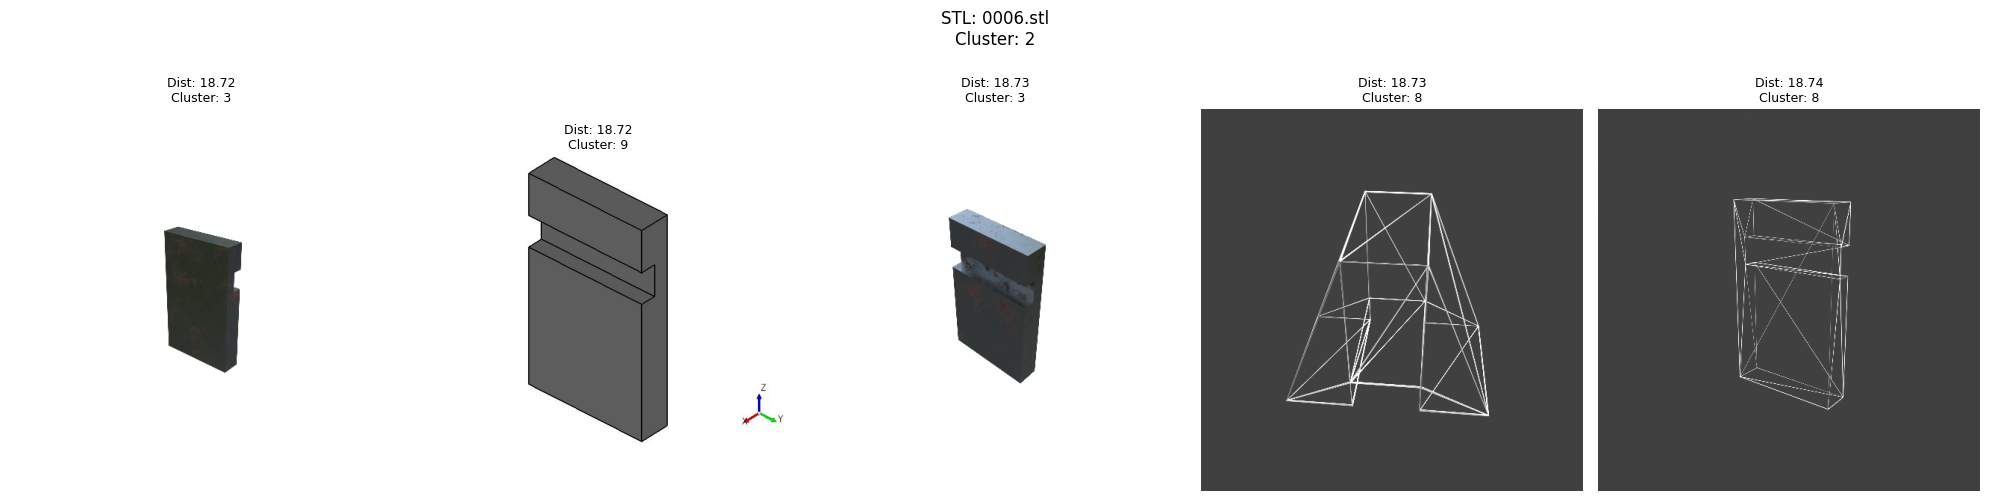

Обработка STL:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [00:04<00:00,  1.77it/s]

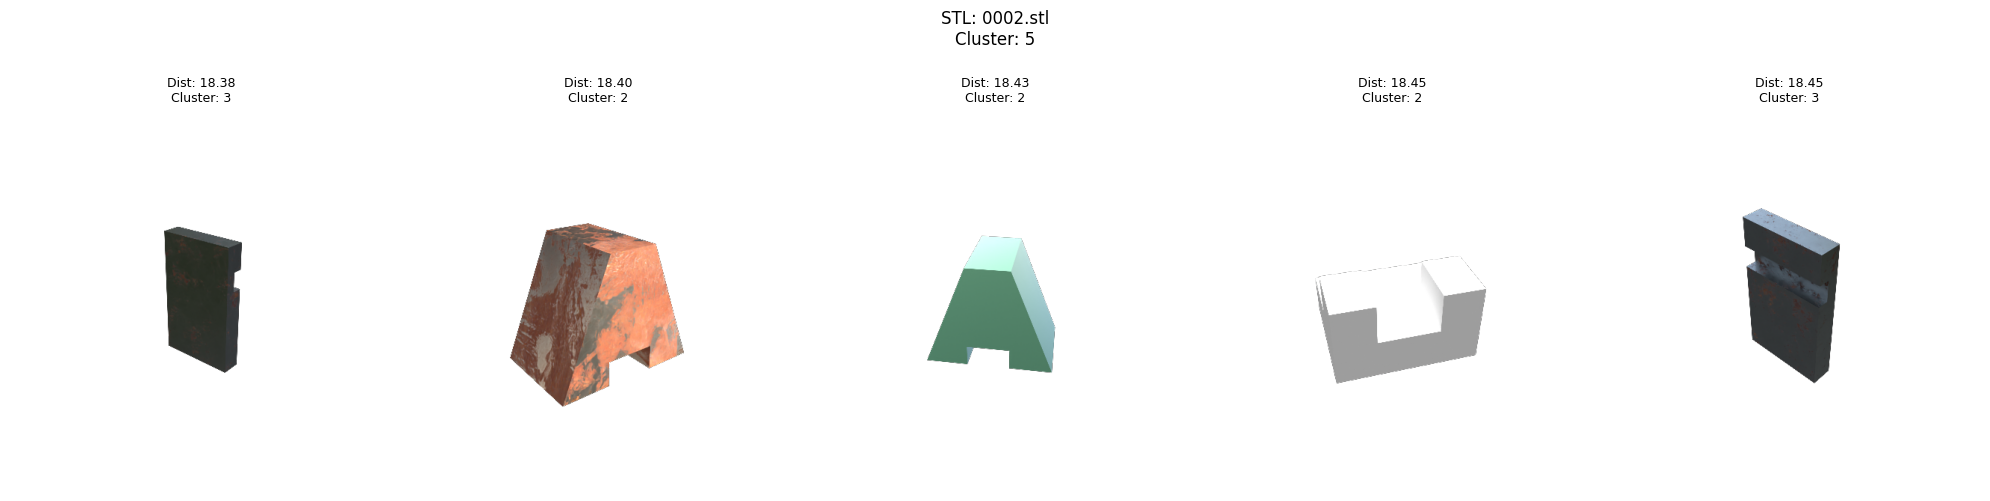

Обработка STL: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.91it/s]


In [195]:
visualize_stl_to_image_neighbors(
    stl_embeddings=stl_embeddings,
    image_embeddings=embeddings,
    stl_paths=stl_paths,
    image_paths=image_paths,
    stl_labels=stl_labels,
    image_cluster_labels=image_cluster_labels,
    n_neighbors=5,
    n_samples=10
    )